<a href="https://colab.research.google.com/github/PGM-Lab/probai-2021-pyro/blob/main/Day3/notebooks/solutions_bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span style="color:red">This notebook is an adapted version from  </span>  http://pyro.ai/examples/bayesian_regression.html

## Setup
Let's begin by installing and importing the modules we'll need.

In [1]:
!pip install -q --upgrade pyro-ppl torch==1.8.1 seaborn 

import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta, Gamma, Binomial
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# for CI testing
pyro.set_rng_seed(1)
pyro.enable_validation(True)

     |████████████████████████████████| 634kB 3.2MB/s 


# Dataset 

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `cont_africa`: whether the given nation is in Africa
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `rgdppc_2000`: Real GDP per capita for the year 2000
 
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially. 

In [2]:
DATA_URL = "https://raw.githubusercontent.com/pyro-ppl/brmp/master/brmp/examples/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [3]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
11,0,0.006,9.212541
12,0,0.143,10.143191
13,0,3.513,10.274632
14,0,1.672,7.852028
15,1,1.780,6.432380


# 1. Logistic Regression

Logistic Regression is one of the most common and basic supervised learning tasks in machine learning. Suppose we're given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of logistic regression is to fit a model that correctly predicts the probabilities of the class labels:

$$ p(y|x) = \frac{1}{1+e^{-b  -w x }}$$

where $w$ and $b$ are learnable parameters. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

Let's first implement logistic regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we'll see how to incorporate uncertainty into our estimates by using Pyro to implement Bayesian logistic regression.

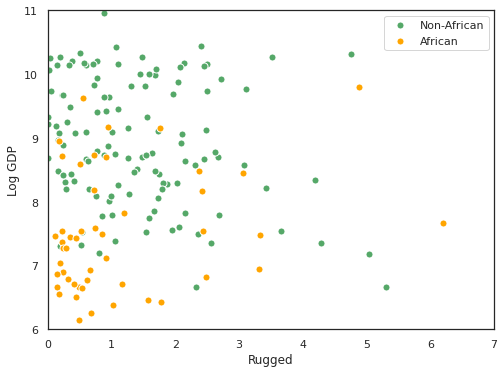

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
data = df.values
x_data, y_data = data[:, (1,2)], data[:, 0]

xx, yy = np.mgrid[0:7:.01, 6:11:.01]
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

f, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x_data[y_data==0,0], x_data[y_data==0, 1], c='g', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='Non-African')

ax.scatter(x_data[y_data==1,0], x_data[y_data==1, 1], c='orange', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='African')


ax.set(aspect="equal",
       xlim=(0, 7), ylim=(6, 11),
       xlabel="Rugged", ylabel="Log GDP")
ax.legend()

## 1.1 Model
We would like to predict whether a nation is african or not as a function of the terrain rugedness index and log GDP per capita of a nation.  Let's define our logistic regression model. We'll define an specific object encapsulating this logistic regression model.  Our input `x_data` is a tensor of size $N \times 2$ and our output `y_data` is a tensor of size $N \times 1$.  The method `predict(self,x_data)` defines a sigmoid transformation of the form $sigmoid(Xw + b)$ where $w$ is the weight matrix and $b$ is the additive bias.

The parameters of the model are defined using ``torch.nn.Parameter``, and will be learned during training. 

In [5]:
class LogisticRegressionModel():
    def __init__(self):
        self.w = torch.nn.Parameter(torch.zeros(1, 2))
        self.b = torch.nn.Parameter(torch.zeros(1, 1))

    def params(self):
        return {"b":self.b, "w": self.w}

    def predict(self, x_data):
        return torch.sigmoid(-self.b - torch.mm(self.w, torch.t(x_data))).squeeze(0)

    def logits(self, x_data):
        return (self.b + torch.mm(self.w, torch.t(x_data))).squeeze(0)

logistic_regression_model = LogisticRegressionModel()

## 1.2 Training
We will use the cross entropy as our loss and Adam as our optimizer. We would like to optimize the parameters of the `logistic_regression_model` neural net above. We will use a somewhat large learning rate of `0.05` and run for 1000 iterations.

In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
optim = torch.optim.Adam(logistic_regression_model.params().values(), lr=0.05)
num_iterations = 5000
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, (1,2)], data[:, 0]

def main():
    for j in range(num_iterations):
        # run the model forward on the data
        logits = logistic_regression_model.logits(x_data)
        # calculate the cross-entropy loss
        loss = loss_fn(logits,y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in logistic_regression_model.params().items():
        print(name, param.data.numpy())

main()

[iteration 0500] loss: 70.1524
[iteration 1000] loss: 69.0927
[iteration 1500] loss: 69.0802
[iteration 2000] loss: 69.0801
[iteration 2500] loss: 69.0801
[iteration 3000] loss: 69.0801
[iteration 3500] loss: 69.0801
[iteration 4000] loss: 69.0801
[iteration 4500] loss: 69.0802
[iteration 5000] loss: 69.0816
Learned parameters:
b [[11.975294]]
w [[-0.32121494 -1.5243033 ]]


## 1.3 Evaluating the model

We now plot the regression line learned for african and non-afrian nations relating the rugeedness index with the GDP of the country.

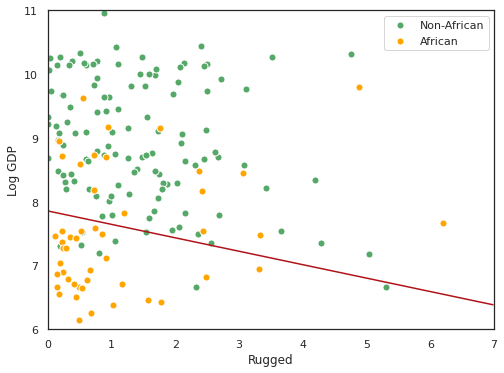

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
xx, yy = np.mgrid[0:7:.01, 6:11:.01]
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
probs = logistic_regression_model.predict(grid).reshape(xx.shape).detach().numpy()

f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Reds", vmin=0, vmax=.6)

ax.scatter(x_data[y_data==0,0], x_data[y_data==0, 1], c='g', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='Non-African')

ax.scatter(x_data[y_data==1,0], x_data[y_data==1, 1], c='orange', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='African')


ax.set(aspect="equal",
       xlim=(0, 7), ylim=(6, 11),
       xlabel="Rugged", ylabel="Log GDP")
ax.legend()

## 1.4 The relationship of ruggedness and log GPD with african/non-african nations



Using this analysis, we can estimate the relationship of ruggedness and log GPD with african and non-african nations. As can be seen, this relationship is positive for African nations, but negative for Non African Nations.

In [8]:
weight_ruggedness = logistic_regression_model.params()['w'][0,0]
weight_logGDP = logistic_regression_model.params()['w'][0,1]
print(weight_ruggedness.data.numpy())
print(weight_logGDP.data.numpy())

-0.32121494
-1.5243033


# 2. Bayesian Logistic Regression


[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over variables that are consistent with the observed data.

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$, $b$ and $f$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

A graphical representation would be as follows:

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day3/Figures/BayesianLogisticRegressionPGM.png" width=800>


## 2.1 Model

We now have all the ingredients needed to specify our model. First we define priors over weights and bias. Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data.

We use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise parameter.

### <span style="color:red">Exercise </span> 
 
* Define a random variable "b" to model the intercept. 
* Define the class random variable "african/non-african" for the predicited labels.
* This random variable is defined as Binomial distribution and is parametrized with the logits. 

In [9]:
def model(x_data, y_data):
    # weight and bias priors
    with pyro.plate("plate_w", 2):
        w = pyro.sample("w", Normal(torch.zeros(1,1), torch.ones(1,1)))

    # Define a random variable "b" to model the intercept. 
    b = pyro.sample("b", Normal(0., 1000.))

    with pyro.plate("map", len(x_data)):
        # Compute logits (i.e. log p(x=0)/p(x=1)) as a linear combination between data and weights. 
        logits = (b + torch.mm(x_data,torch.t(w))).squeeze(-1)
        # Define a Binomial distribution as the observed value parameterized by the logits. 
        pyro.sample("african/non-african", Binomial(logits = logits), obs=y_data)

## 2.2 Guide

In order to do inference we're going to need a guide, i.e. a variational family of distributions.  We will use Pyro's [autoguide library](http://docs.pyro.ai/en/dev/contrib.autoguide.html) to automatically place Gaussians with diagonal covariance on all of the distributions in the model.  Under the hood, this defines a `guide` function with `Normal` distributions with learnable parameters corresponding to each `sample()` in the model.

In [10]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

## 2.3 Inference

To do inference we'll use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)). Just like in the non-Bayesian linear regression, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the ELBO objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

In [11]:
optim = Adam({"lr": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=10)

Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). To take an ELBO gradient step we simply call the step method of SVI. Notice that the data argument we pass to step will be passed to both model() and guide().  The complete training loop is as follows:

In [12]:
num_iterations = 10000
def train(x_data, y_data):
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train(x_data, y_data)

[iteration 0001] loss: 287.0737
[iteration 0501] loss: 14.9879
[iteration 1001] loss: 11.3764
[iteration 1501] loss: 10.6092
[iteration 2001] loss: 10.1554
[iteration 2501] loss: 9.6072
[iteration 3001] loss: 9.0437
[iteration 3501] loss: 8.2546
[iteration 4001] loss: 7.3543
[iteration 4501] loss: 6.4499
[iteration 5001] loss: 5.4493
[iteration 5501] loss: 4.4654
[iteration 6001] loss: 3.4731
[iteration 6501] loss: 2.6715
[iteration 7001] loss: 1.9399
[iteration 7501] loss: 1.3214
[iteration 8001] loss: 0.8799
[iteration 8501] loss: 0.6183
[iteration 9001] loss: 0.5139
[iteration 9501] loss: 0.5062


In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.numpy())

AutoDiagonalNormal.loc [-0.30006382 -1.5279045  12.232048  ]
AutoDiagonalNormal.scale [0.05596961 0.03466691 0.20829546]


As you can see, instead of just point estimates, we now have uncertainty estimates (`auto_scale`) for our learned parameters.  Note that Autoguide packs the latent variables into a tensor, in this case, one entry per variable sampled in our model.

Look like all the data points fall inside the estimated confidence intervals, being able to capture the uncertaintity in our predictions. 

## 2.4 Model Evaluation: Model's Uncertainty
In this case, we'll sample different the logistic regression lines to see how using a Bayesian approach we are able to capture the model undertainty.

In [14]:
def logisticRegressionLineMean(x_data,guide):
    return (pyro.param('AutoDiagonalNormal.loc')[2] + torch.mm(x_data,torch.t(pyro.param('AutoDiagonalNormal.loc')[0:2].reshape(1,2)))).squeeze(-1)

def logisticRegressionPredictions(x_data,guide):
    logits = logisticRegressionLineMean(x_data,guide)
    return Binomial(logits = logits).mean
    
def logisticRegressionLineSample(x_data,guide):
    return (guide()['b'] + torch.mm(x_data,torch.t(guide()['w']))).squeeze(-1)

def logisticRegressionPredictionsSample(x_data,guide):
    logits = logisticRegressionLineSample(x_data,guide)
    return Binomial(logits = logits).mean

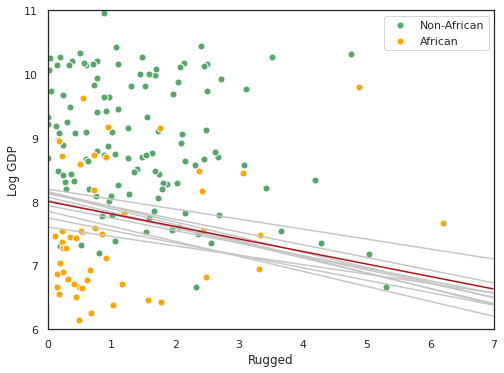

In [15]:
sns.set(style="white")
xx, yy = np.mgrid[0:7:.01, 6:11:.01]
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

f, ax = plt.subplots(figsize=(8, 6))



for i in range(10):
    probs = logisticRegressionPredictionsSample(grid,guide).reshape(xx.shape).detach().numpy()
    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=1.5)

probs = logisticRegressionPredictions(grid,guide).reshape(xx.shape).detach().numpy()
ax.contour(xx, yy, probs, levels=[.5], cmap="Reds", vmin=0, vmax=.6)


ax.scatter(x_data[y_data==0,0], x_data[y_data==0, 1], c='g', s=50,
           cmap="Greens", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='Non-African')

ax.scatter(x_data[y_data==1,0], x_data[y_data==1, 1], c='orange', s=50,
           cmap="Oranges", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='African')


ax.set(aspect="equal",
       xlim=(0, 7), ylim=(6, 11),
       xlabel="Rugged", ylabel="Log GDP")
ax.legend()

The above figure shows the uncertainty in our estimate of the logistic regression line. Note that for lower values of ruggedness there are many more data points, and as such, the regression lines are less uncertainty than in high ruggness values, where there is much more uncertainty. 

## 2.5 The relationship between ruggedness and log GPD

Finally, we can look about the uncertainty about the weights associated to Terrain Rugedness and logarithm of GDP. 

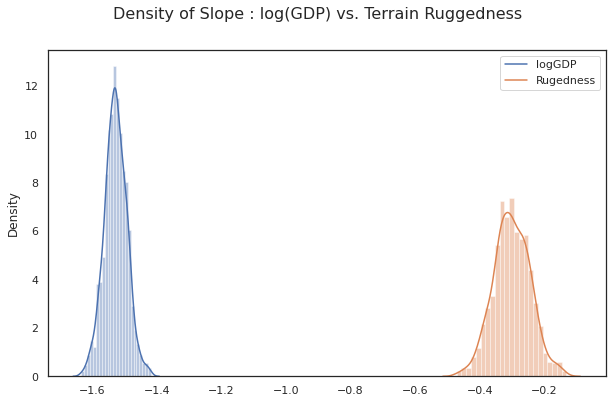

In [16]:
weight = torch.stack([guide()['w'] for i in range(1000)]).squeeze()
weight_rugedness  = weight[:,0]
weight_logGDP = weight[:,1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(weight_logGDP.detach().numpy(), kde_kws={"label": "logGDP"})
sns.distplot(weight_rugedness.detach().numpy(), kde_kws={"label": "Rugedness"},)
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)
plt.legend()
plt.show()

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012